# ValueInvestor
We are looking to establish a robust intelligent system that can aid investment activities, using past stock performance data. 

Our goal in this project is to use provided historical trading data to predict future stock price valuations on a daily, weekly, and monthly basis. We also provide recommendations on whether to BUY, HOLD or SELL each stock based on the predictions.

### Data Description


We are given trading data from 8 different countries in emerging markets that include the 2020 Q1-Q2-Q3-Q4 and 2021 Q1 stock prices. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. We will only 2020 data and predict with 2021 Q1 data.

Each set of data contain the following columns:
- `Date`
- `Price` (The closing price of the stock on a day)
- `Open` (The opening price of the stock on a day)
- `High` (The highest price of the stock on a day)
- `Low` (The lowest price of the stock on a day)
- `Vol.` (The volume/number of shares that were traded on a day)
- `Change %` (The percentage change from the closing price of the previous day)

### Data Loading
Let's first load the data of the first sheet.

In [36]:
# Import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [37]:
df = pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", sheet_name=None)

In [38]:
print(df.keys())

dict_keys(['Russia - Sberbank Rossii PAO (S', 'Turkey - Koc Holding AS (KCHOL)', 'Egypt - Medinet Nasr Housing (M', 'Brazil - Minerva SABrazil (BEEF', 'Argentina - Pampa Energia SA (P', 'Colombia - Cementos Argos SA (C', 'South Africa - Impala Platinum ', 'South Korea - Dongkuk Steel Mil'])


In [39]:
sheet1 = df[list(df.keys())[0]] # Extract the first shee
sheet1 = sheet1.iloc[:-1,:] # Drop the last row
sheet1["Price"].describe(percentiles=[0.25, 0.5, 0.75])

count     311.0
unique    303.0
top       272.0
freq        2.0
Name: Price, dtype: float64

In [40]:
sheet1["Price"].astype(float).describe()

count    311.000000
mean     234.524019
std       32.079847
min      174.270000
25%      207.700000
50%      229.140000
75%      264.380000
max      293.300000
Name: Price, dtype: float64

In [41]:
sheet1["Change %"].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

### Data Exploration

#### Check for missing values

In [42]:
sheet1.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

#### Check for outliers

In [43]:
sns.boxplot(sheet1["Price"])

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Open'>

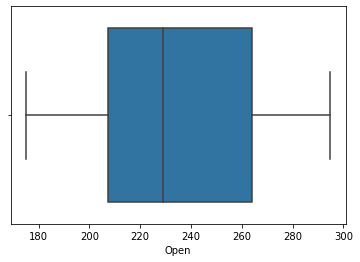

In [44]:
sns.boxplot(sheet1["Open"])

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='High'>

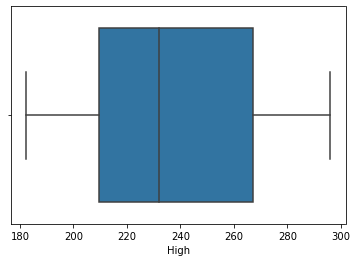

In [45]:
sns.boxplot(sheet1["High"])

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Low'>

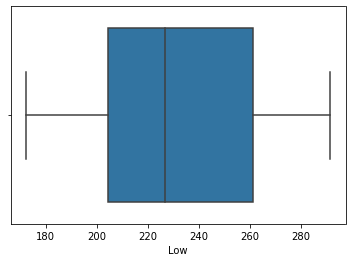

In [46]:
sns.boxplot(sheet1["Low"])

In [47]:
sheet1['Vol.'].str[:-1].astype(float)

0      47.00
1      38.81
2      43.68
3      56.07
4      35.22
       ...  
306    18.85
307    38.33
308    40.82
309    22.35
310    35.85
Name: Vol., Length: 311, dtype: float64

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Vol.'>

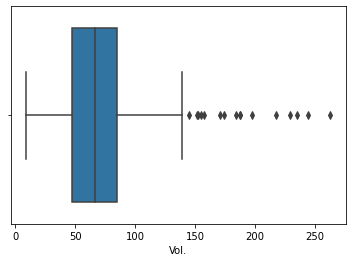

In [48]:
sns.boxplot(sheet1['Vol.'].str[:-1].astype(float))

In [49]:
sns.boxplot(sheet1['Change %'])

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Change %'>

Plot the price over time.

In [50]:
# Convert dates to DateTime
sheet1["Datetime"] = pd.to_datetime(sheet1["Date"],format='%Y-%m-%d %H:%M:%S') 
plt.figure(figsize=(28, 10))
plt.plot(sheet1["Datetime"], sheet1["Price"])
plt.xlabel('Date')
plt.ylabel('Closing Price')


/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_1609/1329123659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sheet1["Datetime"] = pd.to_datetime(sheet1["Date"],format='%Y-%m-%d %H:%M:%S')


Text(0, 0.5, 'Closing Price')

Check assumptions
ARIMAX


### ARIMA (Autoregressive integrated moving average)

#### Check assumptions of the ARIMA model
The following assumptions need to be satisified:
- Data should be stationary
- Data should be univariate

To check that the data is stationary, we can use the ADF (Augmented Dickey-Fuller) Test.

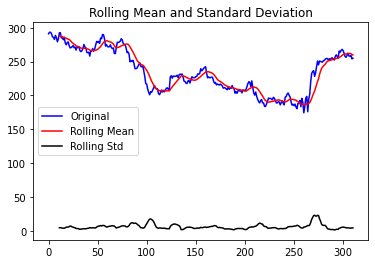

Results of dickey fuller test
Test Statistics                 -1.847182
p-value                          0.357301
No. of lags used                 8.000000
Number of observations used    302.000000
critical value (1%)             -3.452190
critical value (5%)             -2.871158
critical value (10%)            -2.571895
dtype: float64


In [51]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(sheet1.Price)

As the p-value > 0.05, we can't rule out the null hypothesis that a unit root exists in this sample.

Now lets split the data into training and testing data.

In [59]:
sheet1["Datetime"] < datetime.strptime("2020-01-10", "%Y-%m-%d")

0      False
1      False
2      False
3      False
4      False
       ...  
306    False
307     True
308     True
309     True
310     True
Name: Datetime, Length: 311, dtype: bool

In [69]:
train_data = sheet1[sheet1["Datetime"] < datetime.strptime("2020-10-01", "%Y-%m-%d")]
test_data = sheet1[(sheet1["Datetime"] >= datetime.strptime("2020-10-01", "%Y-%m-%d")) & (sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d"))]

In [70]:
train_data.sort_values(by="Date")

Date   Price    Open    High     Low    Vol.  Change %  \
310  2020-01-03 00:00:00   255.0  255.99  258.19   253.7  35.85M    0.0010   
309  2020-01-06 00:00:00   253.9  254.75  254.84   251.4  22.35M   -0.0043   
308  2020-01-08 00:00:00  259.15  253.57  259.15  253.03  40.82M    0.0207   
307  2020-01-09 00:00:00  257.99   259.4  261.76  257.01  38.33M   -0.0045   
306  2020-01-10 00:00:00  258.19  257.86  259.25  256.88  18.85M    0.0008   
..                   ...     ...     ...     ...     ...     ...       ...   
129  2020-09-24 00:00:00  228.17  227.63   231.1  225.75  82.00M   -0.0014   
128  2020-09-25 00:00:00  228.24   229.0   229.3  226.25  60.25M    0.0003   
127  2020-09-28 00:00:00  228.63  228.79  229.55  227.35  64.52M    0.0017   
126  2020-09-29 00:00:00  225.48  228.88  228.88   223.1  90.42M   -0.0138   
125  2020-09-30 00:00:00  229.14   224.5  230.75  223.25  78.60M    0.0162   

      Datetime  
310 2020-01-03  
309 2020-01-06  
308 2020-01-08  
307 2020-01-09  
306 2020-01-10  
..         ...  
129 2020-09-24  
128 2020-09-25  
127 2020-09-28  
126 2020-09-29  
125 2020-09-30  

[186 rows x 8 columns]

In [71]:
test_data.sort_values(by="Date")

Date   Price    Open    High     Low     Vol.  Change %  \
124  2020-10-01 00:00:00  227.23  229.08   229.9  226.86   77.83M   -0.0083   
123  2020-10-02 00:00:00   208.8   210.4  211.39   206.5  114.32M   -0.0811   
122  2020-10-05 00:00:00  208.89  209.65  210.69  207.72   45.60M    0.0004   
121  2020-10-06 00:00:00  211.18   209.0  212.99  208.35   87.53M    0.0110   
120  2020-10-07 00:00:00   210.6   211.3  212.66  209.03   62.05M   -0.0027   
..                   ...     ...     ...     ...     ...      ...       ...   
65   2020-12-24 00:00:00  269.32  271.98  272.82  267.13   42.61M   -0.0029   
64   2020-12-25 00:00:00  270.64  269.97   271.0  268.28   11.99M    0.0049   
63   2020-12-28 00:00:00   274.7   270.9  275.19  269.73   39.04M    0.0150   
62   2020-12-29 00:00:00   272.0  275.91  276.43  271.26   39.02M   -0.0098   
61   2020-12-30 00:00:00  271.65  272.49  274.24  270.12   31.53M   -0.0013   

      Datetime  
124 2020-10-01  
123 2020-10-02  
122 2020-10-05  
121 2020-10-06  
120 2020-10-07  
..         ...  
65  2020-12-24  
64  2020-12-25  
63  2020-12-28  
62  2020-12-29  
61  2020-12-30  

[64 rows x 8 columns]

In [ ]:
train_data, test_data = sheet1["Price"]

In [ ]:
# Split data into train and test sets

In [ ]:
# Fit model on the train set

### Forecast Future Unknown Data

### Summary